1. Загрузите данные из globalterrorismdb_0718dist.xlsx

2. Создайте графы G1 и G2 за 2 разных года (вершиной является eventid, списком смежности related; года должны быть не обязательно последовательными, но не ранее 2000 года)

3. Удалите из графов изолированные вершины и мультиребра

4. Посчитайте для графов G1 и G2 graph edit distance (https://en.wikipedia.org/wiki/Graph_edit_distance). Сделайте вывод о полученном "расстоянии" (3 балла)

5. Посчитайте ключевые метрики для каждого графа: diameter, eccentricity, periphery, girth, expansion. Сделайте вывод о схожести графов (по 0.2 балла за каждую метрику)

6. Посчитайте Wiener_index для каждого графа (https://en.wikipedia.org/wiki/Wiener_index). Сделайте вывод о схожести графов (2 балла)

7. Посчитайте Hosoya_index для каждого графа (https://en.wikipedia.org/wiki/Hosoya_index). Сделайте вывод о схожести графов (2 балла)

8. Для каждого графа найдите ядро. Сделайте вывод о схожести графов (2 балла)

# Для вывода о схожести графов в пп. 5-8 придумайте какую-нибудь метрику, вычисляющую "расстояние" между графами на основе полученных значений индекса/характеристики (и обоснуйте, почему ваша метрика рациональна, т.е. реально отражает схожесть графов в рамках данных расчетных индексов/характеристик)

### Для того, чтобы не знать, пока пандас считает эксельку со всеми годами, я написал вспомогательный код, которая парсит каждый год (я распарсил года с 2005 по 2016) в отдельную эксельку, а затем взял года с компонентами приличного размера относительно других годов. 
### Данный функционал также на всякий случай прилагаю.

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_excel('~/Me/HSE/Graphs/HW_2/gtdb.xlsx')
for i in range(2005, 2016):
    d = df[df['iyear']==i]
    d.to_excel('gtdb_'+str(i)+'.xlsx')

In [2]:
def make_graph(year):
    path = '../gtdb_'+str(year)+'.xlsx'
    d = pd.read_excel(path)
    v, e = d['eventid'].dropna().to_dict(), d['related'].dropna().to_dict()
    g = nx.Graph()
    g.add_nodes_from(np.array(d['eventid'].dropna()))
    
    for key in e.keys():
        for vert in list(map(int, e[key].split(','))):
            g.add_edge(v[key], vert)
    
    #g.remove_nodes_from(nx.isolates(g))
    comps = sorted(nx.connected_components(g), key=len, reverse=True)
    
    c1, c2 = list(comps[0]), list(comps[1])
    ans = nx.Graph()
    ans.add_nodes_from(c1)
    ans.add_nodes_from(c2)
    
    for i in range(len(c1)):
        df = np.array(d[d['eventid']==c1[i]]['related'])
        #print(df)
        for rel in df:
            for vert in list(map(int, rel.split(','))):
                ans.add_edge(c1[i], vert)
            
    for i in range(len(c2)):
        df = np.array(d[d['eventid']==c2[i]]['related'])
        for rel in df:
            for vert in list(map(int, rel.split(','))):
                ans.add_edge(c2[i], vert)
                
    v1, v2 = c1[np.random.randint(len(c1))], c2[np.random.randint(len(c2))]
    ans.add_edge(v1, v2)
    
    return ans, c1, c2, v1, v2

In [3]:
def plot_graph(g):
    f = plt.figure(figsize=(13,15))
    
    _layout = nx.spring_layout(g)
    
    nx.draw_networkx_nodes(g, _layout, cmap=plt.get_cmap('jet'), 
                       node_color = 'g', node_size = 8)
    nx.draw_networkx_edges(g, _layout, edge_color='r')
    
    plt.show()

In [4]:
def check_cliques(g, c1, c2):
    for i in range(len(c1)):
        for j in range(i + 1, len(c1)):
            if not g.has_edge(c1[i], c1[j]):
                return False
    print('c1 OK')
    
    for i in range(len(c2)):
        for j in range(i + 1, len(c2)):
            if not g.has_edge(c2[i], c2[j]):
                return False
    
    return True

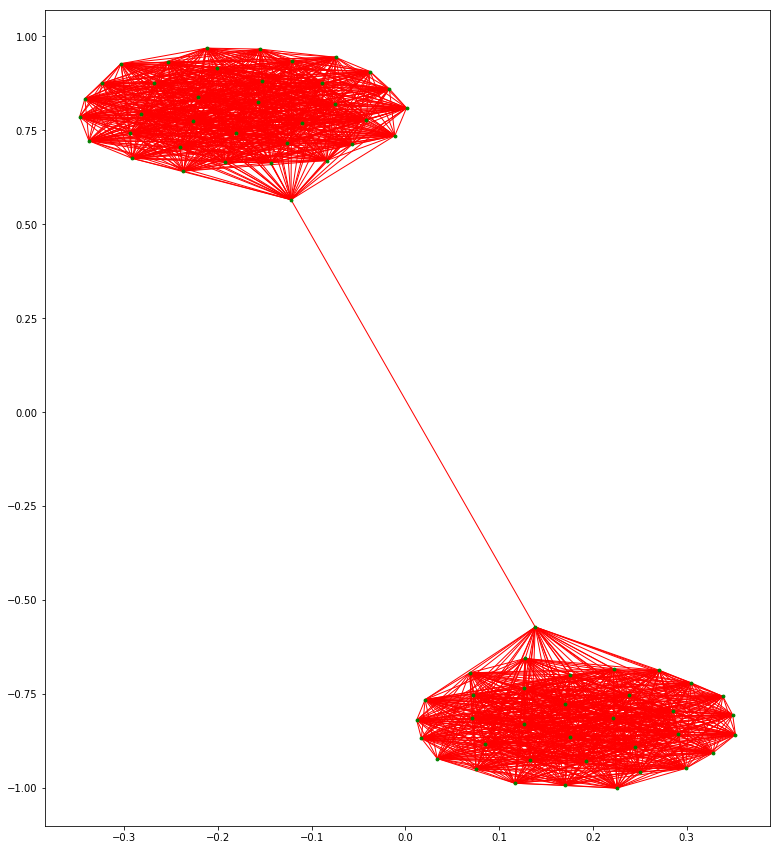

In [5]:
g1, c11, c12, v11, v12 = make_graph(2013)
plot_graph(g1)

In [6]:
check_cliques(g1, c11, c12)

c1 OK


True

In [7]:
print('2013 Graph size is', len(c11) + len(c12))
print(len(c11))
print(len(c12))

2013 Graph size is 71
36
35


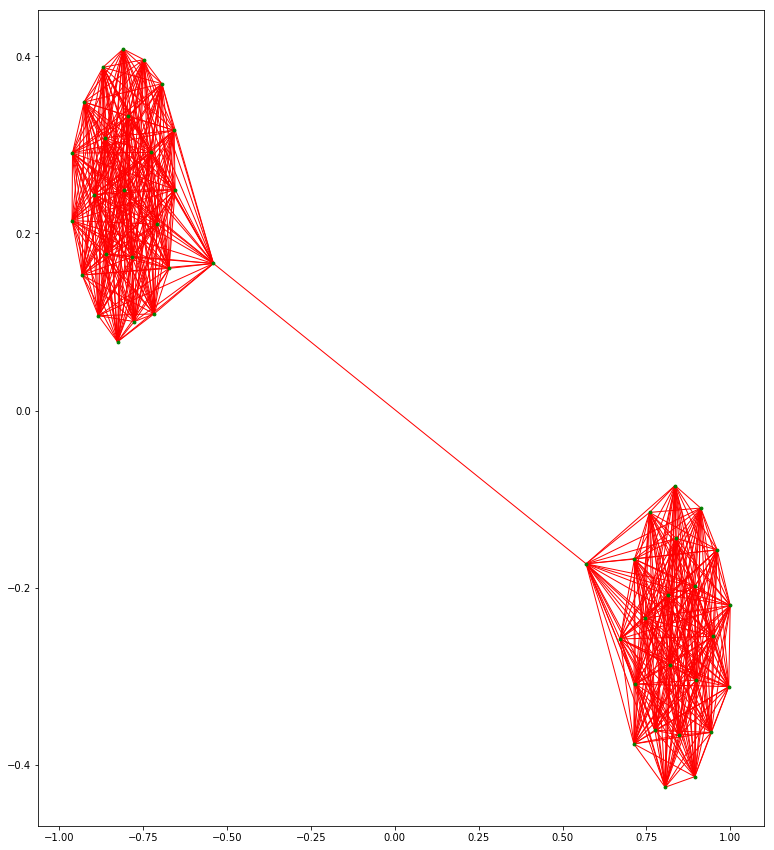

In [8]:
g2, c21, c22, v21, v22 = make_graph(2015)
plot_graph(g2)

In [9]:
check_cliques(g2, c21, c22)

c1 OK


True

In [10]:
print('2015 Graph size is', len(c21) + len(c22))
print(len(c21))
print(len(c22))

2015 Graph size is 47
24
23


### Графы представляют собой 2 клики, связанные мостом. 
### GED на такой паре графов рассчитывается через уравнивание по количеству вершин ближайших клик (а они у нас уже как раз отсорчены по вершинам) и добавлению необходимых ребер. 

### При этом обе клики из 2015 года меньше по размеру соответствующих клик 2013, что позволяет дополнить обе клики 2015го до клик 2013го

### Соответственно, в контексте данной топологии GED можно высчитать пользуясь лишь размером клик, let's do it.


In [11]:
def compute_GED(s11, s12, s21, s22):
    #s11, s12 - 2013 год; s21, s22 - 2015
    v_ans = s11 - s21 + s12 - s22
    e_ans = 0
    for i in range(s21, s11):
        e_ans += i
    for i in range(s22, s12):
        e_ans += i
    return v_ans + e_ans

In [12]:
print(compute_GED(len(c11), len(c12), len(c21), len(c22)))

720


### Оба графа имеют схожую структуру, что мы увидем и далее, при подсчете остальных характеристик. И хотя по значению GED сложно судить о той же схожести графов, в силу сильной зависимости данной характеристики от топологии,  GED (по крайней мере в случае моей топологии) отражает различие размера графов в контексте вершин и ребер.   

### Диаметр клики = 1, учитывая мост, диаметр каждого графа = 3

### Эксцентрисет для вершин, не содержащих мост = 3, а для мостовых вершин = 2.

### Периферия графа является подграфом нашего графа, в котром эксцентрисет каждой вершины эквивалентен диаметру. Следовательно, в периферию каждого графа войдут все вершины, не содержащие мост.

### Girth графа = длина кратчайшего цикла. В контексте моей топологии циклы содержатся только внутри клик, в которых очевидно кратчайший цикл содержит любые 3 вершины из клики и соответствующие смежные ребра. При этом заметим, что добавление доп. ребер между кликами не изменит значение данного индекса, например, в силу того, что кратчайших цикл в графе без мультиребер и изолированных вершин составляет как минимум 3 вершины. 

## Все четыре характеристики эквивалентны для обоих графов, что указывает на схожесть данных графов, причем без нормировки

### Для индекса виннера требуется просуммировать кратчайшие расстояния между всеми парами вершин. 
### Для вершин внутри клик и для пары мостовых вершин d = 1.
### Для мостовой вершины и не мостовой вершины другой клики данное расстояние будет равно 2.
### Для не мостовых вершин из разных клик расстояние равно 3.

In [13]:
def wienner_idx(n1, n2):    
    
    inside_d = n1 * (n1 - 1) / 2 + n2 * (n2 - 1) / 2 + 1 
    
    br_click_d = (n1 - 1) * 2 + (n2 - 1) * 2
    
    outside_d = (n1 - 1) * (n2 - 1) / 2 * 3
    
    return inside_d + br_click_d + outside_d

In [14]:
w1, w2 = wienner_idx(len(c11), len(c12)), wienner_idx(len(c21), len(c22))
e_size1, e_size2 = len(g1.edges()), len(g2.edges())

In [15]:
print(w1, w1/e_size1)
print(w2, w2/e_size2)

3149.0 2.427910562837317
1379.0 2.389948006932409


### Как можно заметить нормированный по количеству ребер индекс Винера почти равен у двух графов, имеющих схожую структуру, но различия в числе вершин и ребер. Cхожесть нормированного значения еще раз указывает на схожесть графов.

### Индекс Хосойя для клики задается телефонными номерами, расчитывающимися по формуле T(n) = T(n - 1) + (n - 1) * T(n - 2).  T(0) = T(1) = 1
### Отлично, тогда кол-во различных парсочей, не включающих мост равно T(clique1_size) * T(clique2_size).
### Теперь посчитаем кол-во парсочей с мостом. Раз мы всегда включаем в парсоч мост, то вершины моста нам уже не интересны и мысленно удалив их из графа, у нас остались опять две клики размером на 1 меньше. Тогда кол-во таких парсочей равняется T(clique1_size - 1) * T(clique2_size - 1)
### Соответственно, индекс Хосойя будет равен сумме этих двух показателей

In [16]:
def tel_numbers(n):
    t0, t1, cur_t = 1, 1, 0
    for i in range(2, n + 1):
        cur_t = t1 + (i - 1) * t0
        t0 = t1
        t1 = cur_t
    return cur_t

In [17]:
tel_numbers(5)

26

In [18]:
def Hosoya(n1, n2):
    val1 = tel_numbers(n1) * tel_numbers(n2)
    val2 = tel_numbers(n1 - 1) * tel_numbers(n2 - 1)
    
    return val1 + val2

In [19]:
h1, h2 = Hosoya(len(c11), len(c12)), Hosoya(len(c21), len(c22))

In [20]:
print(h1, h2)

210626686751716653410293343533848461323534336 59003055601856755514687488


In [21]:
print(round(abs(h1 - h2) / abs(tel_numbers(len(c11) + len(c12)) - tel_numbers(len(c21) + len(c22))), 2))

0.0


In [22]:
print(abs(h1 - h2) / abs(tel_numbers(e_size1) - tel_numbers(e_size2)))

0.0


### Как можно видеть, нормированный индекс Хосойя также указывает на схожесть графов.

### Теперь поймем, как легко находить ядро подобных графов. 
### Нам нужна внутренняя устойчивость, что значит, что каждая пара вершин из множества не смежна. Тогда, в нашем случае мы можем взять максимум по 1 вершине из каждой клики. Но также надо не забывать про мосты и, соответственно, не брать вершины, составляющие мост.
### Взяв такие вершины из каждой клики мы бонусом получаем сразу внешне устойчивое множество, ибо каждая оставшаяся вершина принадлежит какой-либо клике и, соответственно, смежна вершине из множетсва, принадлежащей данной клике.
### Тогда, мы можем брать рандомную вершину из каждой клики, пока не найдем вершину, не принадлежающую мостам. 

In [23]:
def kernel_find(g, c1, c2):
    n1, n2 = len(c1), len(c2)
    
    while True:
        num1, num2 = np.random.randint(n1), np.random.randint(n2)
        v1, v2 = c1[num1], c2[num2]
        if not g.has_edge(v1, v2):
            return v1, v2

In [24]:
print(kernel_find(g1, c11, c12), v11, v12)

(201310090052, 201304150012) 201310090036 201304150045


In [25]:
print(kernel_find(g2, c21, c22), v21, v22)

(201502090044, 201505140092) 201502090052 201505140104


### Как можно видеть, в ядра действительно не входят вершины, принадлежащие мостам.
### Одинаковая размерность ядер отражает схожесть структуры графов (одинаковое число компонент, схожая топология)